# **Curso de Especialização em Big Data, Data Science e Data Analytics - 2021/1**

**Algoritmos e Data Science**

Grupo 10:

- Diogo Gnutzmann Santos    
- Evandro Schubert Faleiro    
- Lucas Sagrilo dos Santos    
- Luis Dinarte Escobar Resende

Fonte do dataset: https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

# **1. Business Understanding**

Por ano, morrem no mundo em média 17 milhões de pessoas de doenças relacionadas ao coração, somente o Brasil totaliza cerca de 360 mil dessas mortes. Sendo que boa parte desses números são de ataques cardíacos, conhecido também como infarto. 
O infarto caracteriza-se pela interrupção do fluxo de sangue oxigenado para o coração, fato esse que gera uma lesão muscular no órgão. Esse problema é causado por diversos fatores e entre eles podemos citar os maus hábitos e até mesmo questões genéticas, porém através de algumas características é possível se tentar predizer se determinado indivíduo tem maior ou menor chance de ser acometido de uma parada cardíaca.
Nesse trabalho vamos analisar os dados históricos de saúde de um conjunto de indivíduos e através da aplicação de algoritmos de machine learning procurar identificar qual estabelece a melhor correlação dos dados com a possibilidade de uma parada cardíaca e assim viabiliar se fazer predições mais assertivas da possibilidade, ou não, de futuras ocorrências.
A identificação antecipada de um possível ataque cardíaco permite que o indivíduo possa receber tratamento prévio de forma a evitá-lo, o que além de salvá-lo também o traria melhor qualidade de vida.
Dessa forma, a escolha adequada de um algoritmo de machine learning pode salva muitas vidas através das suas predições. 
Em se tratando de vida ou morte, qualquer vida que possa ser salva através de alguma predição já teria um grande valor, entretanto colocamos como objetivo nesse trabalho  identificar o algoritmo que além de possibilitar as melhores predições também apresente um adequado balaceamento entre as métricas de acurácia, precisão e recall, essa última também conhecida como revocação ou sensibilidade.
Entendemos ter o nosso objetivo alcançado ao identificar o algoritmo que consiga para todas as métricas valores superiores a 75%, o que garantiria boas predições.

# **2. Data Understanding**

Importar todas as bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling as pp

import plotly.express as px
import plotly.graph_objs as go

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D

from collections import Counter
from xgboost import XGBClassifier

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Importar dataset

In [2]:
data_url = 'https://raw.githubusercontent.com/gnutzmann/heart-attack/main/heart.csv'
raw_df = pd.read_csv(data_url)

In [3]:
raw_df.head(10)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Dicionário de Dados

Coluna   | Descrição
---------|----------------------------------------------------
age      | Idade da pessoa
sex      | Gênero da pessoa</br>0 - Feminino</br>1 - Masculino
cp       | Tipo de dor no peito</br>Valor 1: Angina Típica</br>Valor 2: Angina Atipica</br>Valor 3: Sem angina</br>Valor 4: Assintomático
trtbps   | Pressão sanguínea em repouso em (mm Hg)
chol     | Colesterol em mg/dl por meio de sensor IMC
fbs      | Açucar no sangue em jejum
restecg  | Eletrocardiograma em repouso</br>Valor 0: Normal</br>Valor 1: Tem anormalidade da onda ST-T (Inversões da onda T e / ou elevação ou depressão ST> 0,05 mV)</br>Valor 2: Mostra hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes	
thalachh | Frequência Cardíaca Máxima Alcançada
exng     | Angina Induzida por Exercício</br>1 = Sim</br>    0 = Não</br>
oldpeak  | Pico anterior
slp      | A inclinação do segmento ST de pico do exercício
output   | 0 = Menos chance de ter um ataque cardíaco</br> 1= Mais chance de ter um ataque cardíaco

In [4]:
# Prepara dataset com as literais para gerar os gráficos de Data Understanding
plot_df = raw_df.copy(deep=True)

plot_df['sex'] = np.where(plot_df['sex']==1, 'Masculino', 'Feminino')
plot_df['cp'] = np.where(plot_df['cp']==0, 'Angina Típica', np.where(plot_df['cp']==1, 'Angina Atípica',
    np.where(plot_df['cp']==2, 'Sem angina', np.where(plot_df['cp']==3, 'Assintomático', 0))))
plot_df['fbs'] = np.where(plot_df['fbs']==1, 'Sim', 'Não')
plot_df['restecg'] = np.where(plot_df['restecg']==0, 'Normal', 'Anormal')
plot_df['exng'] = np.where(plot_df['exng']==1, 'Sim', 'Não')

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [6]:
raw_df.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

In [7]:
print("Total de registros: ",len(raw_df.index))

Total de registros:  303


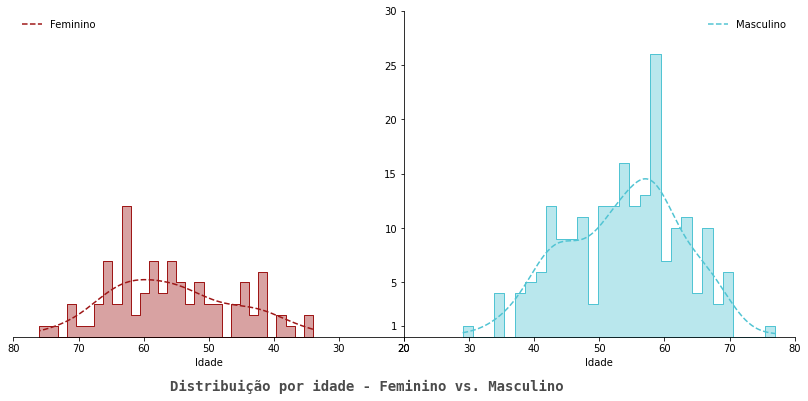

In [8]:
fig,ax = plt.subplots(1,2,figsize=(14,6),sharey=False)

sns.histplot(plot_df[plot_df['sex']=='Feminino']['age'],ax=ax[0],bins=30,alpha=0.4,color='#9E1717',
             element='step',kde=True,line_kws={'ls':'--'})

ax[0].set_xlim(20,80)
ax[0].set_ylim(0,30)
ax[0].invert_xaxis()
ax[0].spines['top'].set_color(None)
ax[0].spines['left'].set_color(None)
ax[0].yaxis.tick_right()
ax[0].set_ylabel(None)
ax[0].set_yticks([])
ax[0].set_xlabel('Idade')
ax[0].legend(['Feminino'],loc='upper left',frameon=False)


sns.histplot(plot_df[plot_df['sex']=='Masculino']['age'],ax=ax[1],bins=30,alpha=0.4,color='#51C4D3',
             element='step',kde=True,line_kws={'ls':'--'})

ax[1].set_xlim(20,80)
ax[1].set_ylim(0,30)
ax[1].spines['top'].set_color(None)
ax[1].spines['right'].set_color(None)
ax[1].set_ylabel(None)
ax[1].set_yticks([1,5,10,15,20,25,30])
ax[1].set_xlabel('Idade')
ax[1].legend(['Masculino'],loc='upper right',frameon=False)

fig.text(s='Distribuição por idade - Feminino vs. Masculino',size=14,fontweight='bold',
             fontname='monospace',color="#1F1F1F",y=0,x=0.28,alpha=0.8)

fig.subplots_adjust(wspace=0)

plt.show()

[Text(0, 0.5, 'Quantidade'), Text(0.5, 0, 'Possibilidade')]

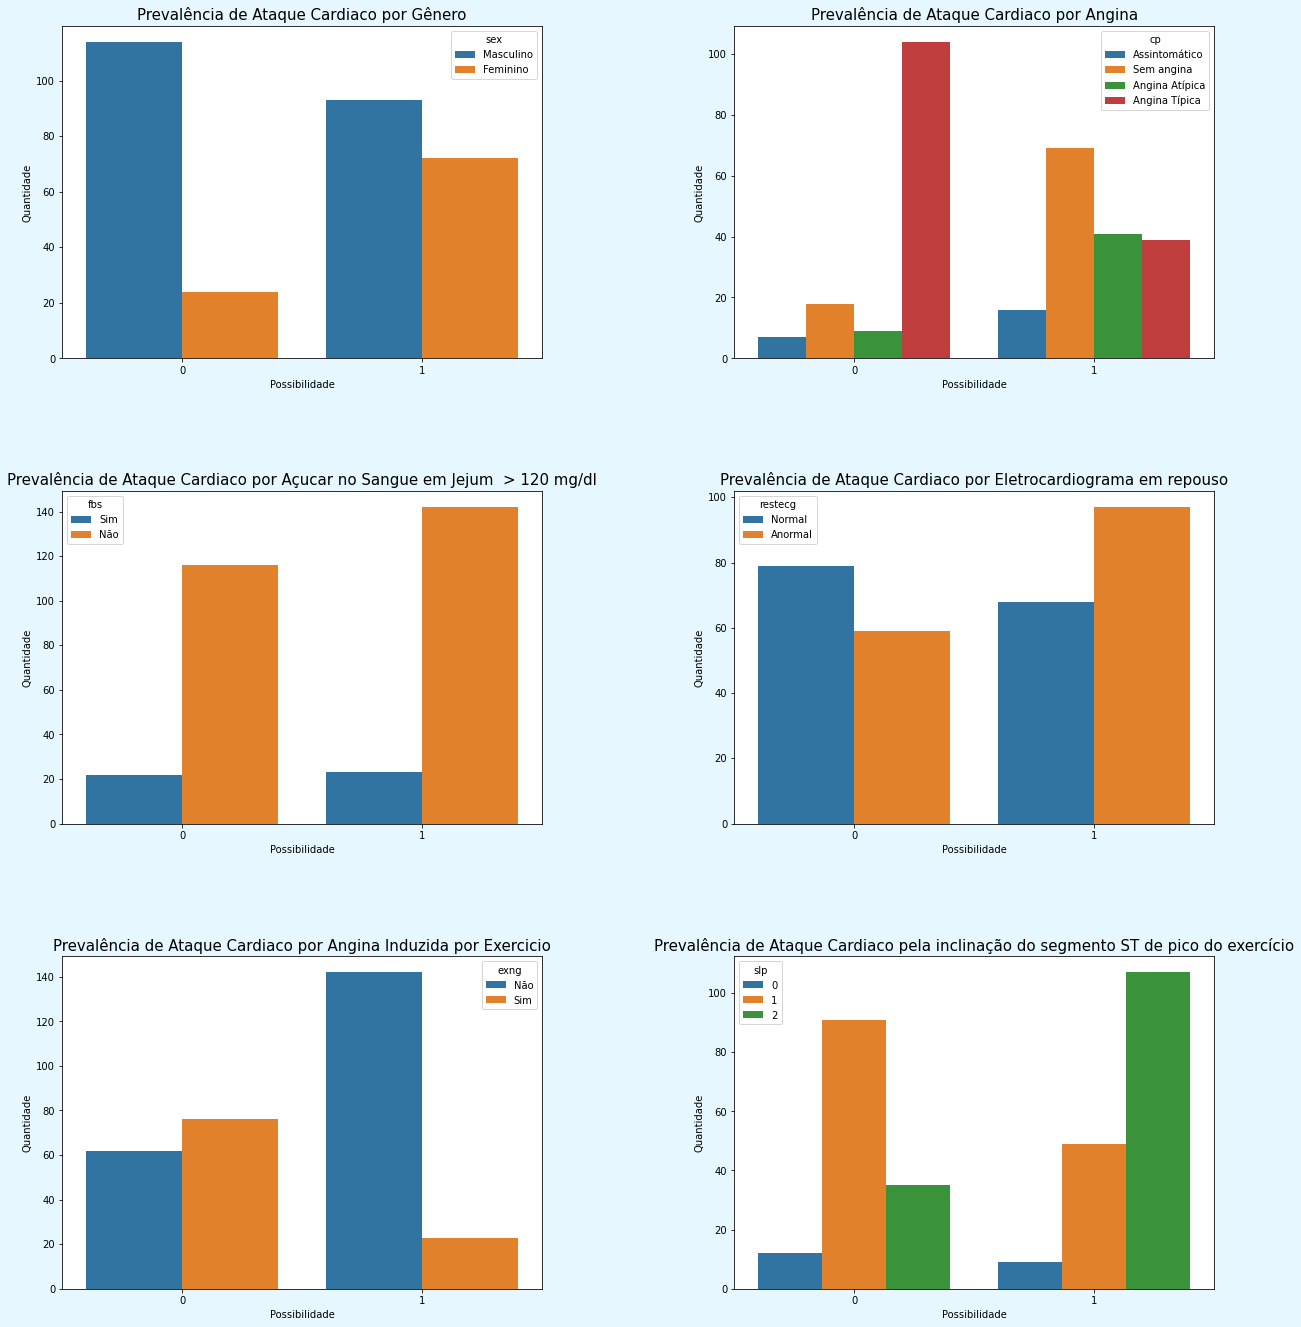

In [9]:
plt.figure(figsize=(20,30)).patch.set_facecolor("#e6f7ff") 
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.subplot(4,2,1)
plt.title('Prevalência de Ataque Cardiaco por Gênero',fontsize=15)
g = sns.countplot(plot_df['output'], hue=plot_df['sex'])
g.set(xlabel = 'Possibilidade', ylabel = 'Quantidade')

plt.subplot(4,2,2)
plt.title('Prevalência de Ataque Cardiaco por Angina',fontsize=15)
g = sns.countplot(plot_df['output'], hue=plot_df['cp'])
g.set(xlabel = 'Possibilidade', ylabel = 'Quantidade')

plt.subplot(4,2,3)
plt.title('Prevalência de Ataque Cardiaco por Açucar no Sangue em Jejum  > 120 mg/dl',fontsize=15)
g = sns.countplot(plot_df['output'],hue=plot_df['fbs'])
g.set(xlabel = 'Possibilidade', ylabel = 'Quantidade')

plt.subplot(4,2,4)
plt.title('Prevalência de Ataque Cardiaco por Eletrocardiograma em repouso',fontsize=15)
g = sns.countplot(plot_df['output'],hue = plot_df['restecg'])
g.set(xlabel = 'Possibilidade', ylabel = 'Quantidade')

plt.subplot(4,2,5)
plt.title('Prevalência de Ataque Cardiaco por Angina Induzida por Exercicio',fontsize=15)
g = sns.countplot(plot_df['output'],hue=plot_df['exng'])
g.set(xlabel = 'Possibilidade', ylabel = 'Quantidade')

plt.subplot(4,2,6)
plt.title('Prevalência de Ataque Cardiaco pela inclinação do segmento ST de pico do exercício',fontsize=15)
g = sns.countplot(plot_df['output'],hue=plot_df['slp'])
g.set(xlabel = 'Possibilidade', ylabel = 'Quantidade')


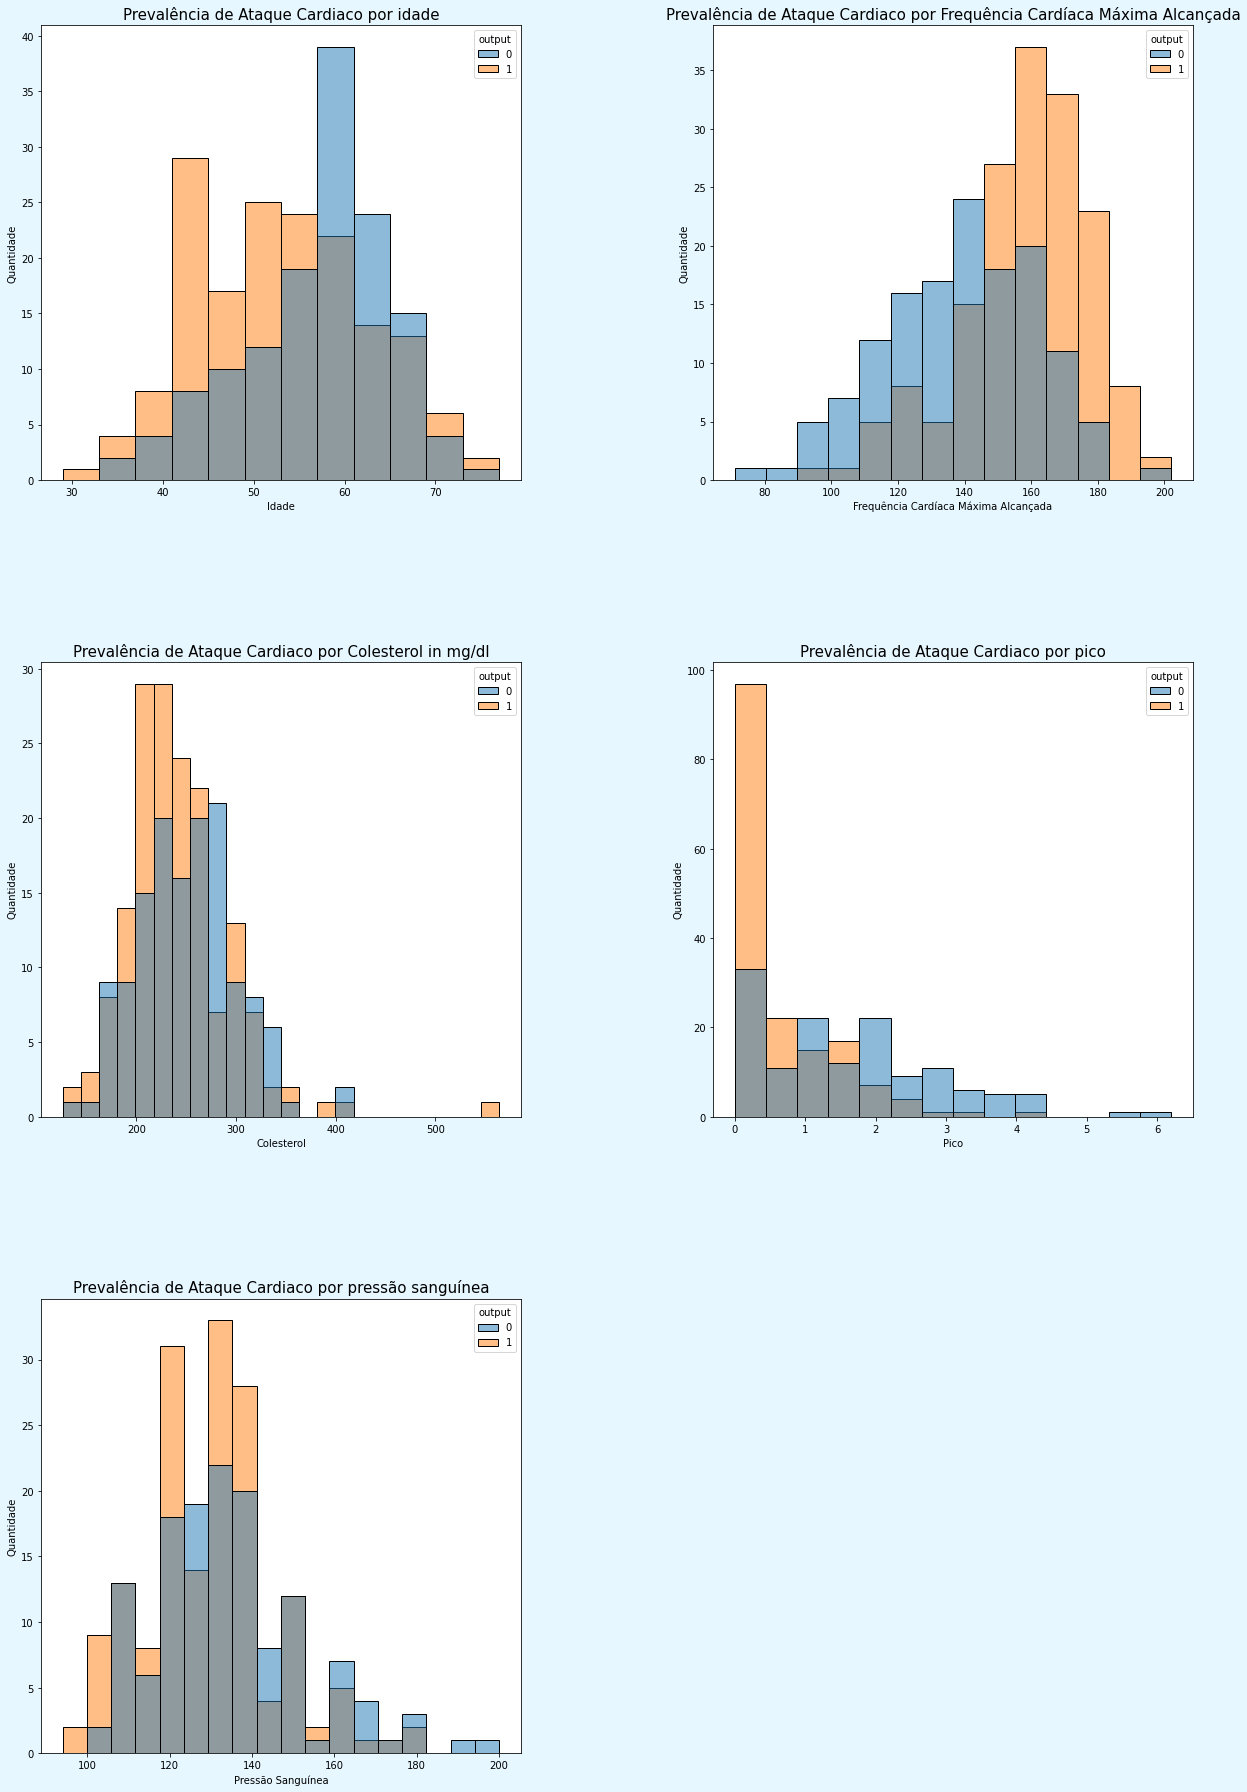

In [10]:
plt.figure(figsize=(20,30)).patch.set_facecolor("#e6f7ff") 
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.subplot(3,2,1)
plt.title('Prevalência de Ataque Cardiaco por idade',fontsize=15)
g = sns.histplot(x = plot_df['age'], hue = plot_df['output'])
g.set(xlabel = 'Idade', ylabel = 'Quantidade')

plt.subplot(3,2,2)
plt.title('Prevalência de Ataque Cardiaco por Frequência Cardíaca Máxima Alcançada',fontsize=15)
g = sns.histplot(x = plot_df['thalachh'], hue = plot_df['output'])
g.set(xlabel = 'Frequência Cardíaca Máxima Alcançada', ylabel = 'Quantidade')

plt.subplot(3,2,3)
plt.title('Prevalência de Ataque Cardiaco por Colesterol in mg/dl',fontsize=15)
g = sns.histplot(x = plot_df['chol'], hue = plot_df['output'])
g.set(xlabel = 'Colesterol', ylabel = 'Quantidade')

plt.subplot(3,2,4)
plt.title('Prevalência de Ataque Cardiaco por pico',fontsize=15)
g = sns.histplot(x = plot_df['oldpeak'],hue = plot_df['output'])
g.set(xlabel = 'Pico', ylabel = 'Quantidade')

plt.subplot(3,2,5)
plt.title('Prevalência de Ataque Cardiaco por pressão sanguínea',fontsize=15)
g = sns.histplot(x = plot_df['trtbps'],hue = plot_df['output'])
g.set(xlabel = 'Pressão Sanguínea', ylabel = 'Quantidade')

conti_cols:  ['age', 'thalachh', 'chol', 'thalachh']

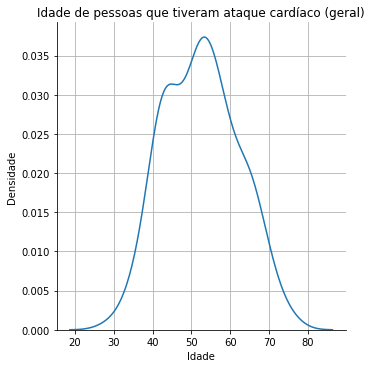

In [11]:
attack = plot_df[raw_df['output']==1]
g = sns.displot(attack.age, kind='kde')

legend = g._legend

plt.xlabel('Idade')
plt.ylabel('Densidade')
plt.title('Idade de pessoas que tiveram ataque cardíaco (geral)')    

plt.grid(True)

plt.show()

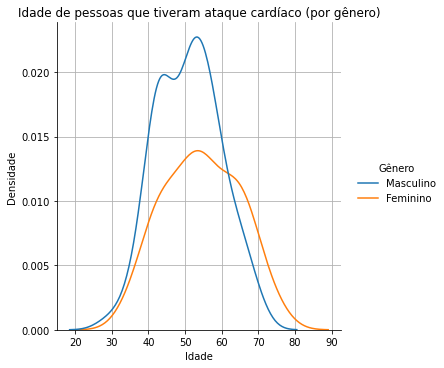

In [12]:
attack = plot_df[raw_df['output'] == 1]

g = sns.displot(x='age', kind='kde', hue='sex', data=attack)

legend = g._legend
legend.set_title("Gênero")

plt.grid(True)


plt.xlabel('Idade')
plt.ylabel('Densidade')
plt.title('Idade de pessoas que tiveram ataque cardíaco (por gênero)')    

plt.show()

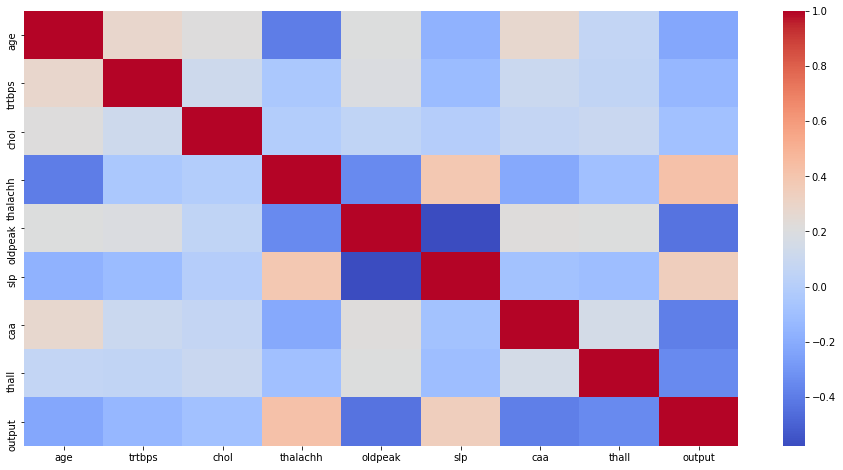

In [13]:
# correlação entre as variáveis
plt.figure(figsize=(16,8))

correlacao = plot_df.corr()
correlacao = (correlacao)
ax = sns.heatmap(correlacao,
            cmap="coolwarm")

ax

# **3. Data Preparation**

Inicializar Dataset de Preparação

In [14]:
prepare_df = raw_df.copy(deep=True)

Verificar se existem valores NULL no dataset

In [15]:
df_length = prepare_df.shape[0]

for col in prepare_df.columns:
    null_count = prepare_df[col].isnull().sum()
    if null_count == 0:
        print("{} tem {} valor nulos ({}%)".format(col, null_count, 0))      
        continue
        
    null_ratio = np.round(null_count/df_length * 100, 2)
    print("{} tem {} valor nulos ({}%)".format(col, null_count, null_ratio))


age tem 0 valor nulos (0%)
sex tem 0 valor nulos (0%)
cp tem 0 valor nulos (0%)
trtbps tem 0 valor nulos (0%)
chol tem 0 valor nulos (0%)
fbs tem 0 valor nulos (0%)
restecg tem 0 valor nulos (0%)
thalachh tem 0 valor nulos (0%)
exng tem 0 valor nulos (0%)
oldpeak tem 0 valor nulos (0%)
slp tem 0 valor nulos (0%)
caa tem 0 valor nulos (0%)
thall tem 0 valor nulos (0%)
output tem 0 valor nulos (0%)


Remover linhas duplicadas

In [16]:
prepare_df.drop_duplicates(inplace=True)
print('O dataset possui ',raw_df.shape[0], ' linhas e ', prepare_df.shape[1], 'colunas.')

O dataset possui  303  linhas e  14 colunas.


Separando 30% dos dados para utilizar como teste e 70% para treinamento do modelo

In [17]:
x_df = raw_df.iloc[:,0:13].values
y_df = raw_df.iloc[:,13].values

x_train, x_test, y_train, y_test = train_test_split(x_df,y_df,test_size = 0.2,random_state = 0)

# **4. Modeling**

Acurácia utilizando algoritmo Randon Forest

In [18]:
model_rdf = RandomForestRegressor(n_estimators = 100, random_state = 0)  

model_rdf.fit(x_train, y_train)  
predicted_rdf = model_rdf.predict(x_test)

acuracy_rdf = accuracy_score(y_test, predicted_rdf.round())*100

print("A acurácia do algoritmo Random Forest é: ", acuracy_rdf, "%")

A acurácia do algoritmo Random Forest é:  81.9672131147541 %


Acurácia utilizando algoritmo SVC

In [19]:
model_svc = SVC()
model_svc.fit(x_train, y_train)
  
predicted_svc = model_svc.predict(x_test)

acuracy_svc = accuracy_score(y_test, predicted_svc)*100

print("A acurácia do algoritmo SVC é: ", acuracy_svc, "%")

A acurácia do algoritmo SVC é:  68.85245901639344 %


Acurácia utilizado algoritmo KNN

In [20]:
model_knn = KNeighborsClassifier(n_neighbors = 1)  
model_knn.fit(x_train, y_train)
predicted_knn = model_knn.predict(x_test)
  
print(confusion_matrix(y_test, predicted_knn))

acuracy_knn = accuracy_score(y_test, predicted_knn.round())*100

print("A acurácia do algoritmo KNN é: ", acuracy_knn, "%")  

[[12 15]
 [14 20]]
A acurácia do algoritmo KNN é:  52.459016393442624 %


Acurácia utilizado algoritmo de Regressão Logistica

In [21]:
model_lr = LogisticRegression(solver='lbfgs', max_iter=1000)
model_lr.fit(x_train, y_train)
predicted_lr=model_lr.predict(x_test)
conf = confusion_matrix(y_test, predicted_lr)

acuracy_lr = accuracy_score(y_test, predicted_lr)*100

print ("Matrix Confusão : \n", conf)
print ("A acurácia do algoritmo Regressão Logistica é: ", acuracy_lr, "%")

Matrix Confusão : 
 [[21  6]
 [ 3 31]]
A acurácia do algoritmo Regressão Logistica é:  85.24590163934425 %


Acurácia utilizando o algoritmo KNN Otimizado

In [22]:
model_knno = KNeighborsClassifier(n_neighbors = 7)
  
model_knno.fit(x_train, y_train)
predicted_knno = model_knno.predict(x_test)
  
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, predicted_knno))

acuracy_knno = accuracy_score(y_test, predicted_knno.round())*100

print("A acurácia do KNN Otimizado é: ", acuracy_knno, "%")

[[18  9]
 [11 23]]
A acurácia do KNN Otimizado é:  67.21311475409836 %


# **5. Evaluation**

Os resultados dos modelos testados são mostrados abaixo e podemos ver que o algoritmo de Regressão Logistica prevê este conjunto de dados da melhor maneira.

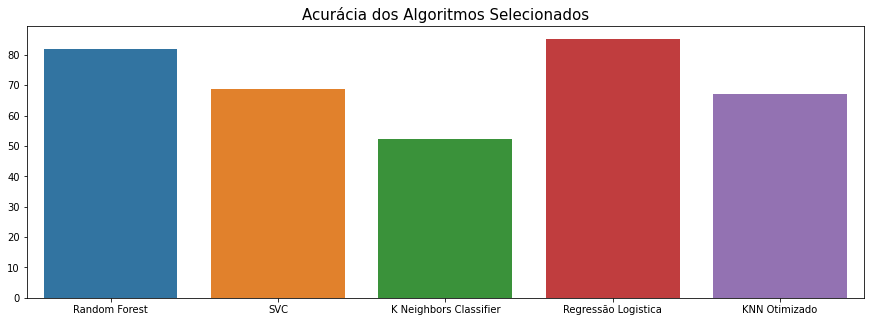

In [23]:


model_names = ['Random Forest', 'SVC', 'K Neighbors Classifier', 'Regressão Logistica', 'KNN Otimizado']
scores = [acuracy_rdf, acuracy_svc, acuracy_knn, acuracy_lr, acuracy_knno]

plt.figure(figsize = (15,5))
plt.title('Acurácia dos Algoritmos Selecionados',fontsize=15)
g = sns.barplot(x = model_names, y = scores)

plt.show()

# **6. Deployment**

# **Conclusão**

Após a escolha e a análise de cinco algoritmos, os quais podem ser observados na etapa de Evaluation, identificamos que o de Regressão Logística foi o que apresentou o maior percentual de acurácia, totalizando 85,25%.
Entretanto, conforme estabelecido como nosso objetivo, ainda precisávamos que o mesmo apresentasse uma balanceamento com as métricas de precisão e de recall/revocação/sensibilidade e todas com valor não inferior a 75%.
Ao calcularmos essas métricas, através da Matriz de Confusão, identificamos o seguinte:
- Acurácia = (VP + VN) / (VP + FN + VN + FP) = (21 + 31) / (21 + 6 + 31 + 3) = 0,8524590163934426 * 100 = **85,25%**;
- Precisão = VP / (VP + FP) = 21 / (21 + 3) = 0,875 * 100 = **87,50%**; 
- Recall = VP / (VP + FN) = 21 / (21 + 6) = 0,778 * 100 = **77,78%**

Dessa forma, entendemos ser o algoritmo de Regressão Logística o que, com a volumetria e colunas com os quais foi treinado, o que melhor adere ao nosso objetivo.